# Project: Exploration of Income Tax Data

* The IRS supplies personal income tax statistics organized by zip code.

* Includes data on income, special tax credits and deductions, number of dependents, and more.

* Over 30,000 zip codes with 120 features for each one.

* The distribution has a long tail extending to $1.2 million.

In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import xgboost as xgb
import sklearn
%matplotlib inline

import seaborn as sns
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

In [3]:
#import data and rename columns
#years = ['09','10','11','12','13','14']
years = ['14']
labels = {'N1': 'num_returns','N2' : 'num_exemp', 'A00100' : 'agi'}
data = {}
for year in years:
    data[year] = pd.read_csv('../Data Incubator/20'+year+'zipcode/'+year+'zpallagi.csv')
    data[year].rename(columns = labels, inplace = True)

In [132]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import shapefile as shp

In [133]:
sf = shp.Reader('cb_2014_us_zcta510_500k/cb_2014_us_zcta510_500k')
shapes = sf.shapes()
records = sf.records()

In [134]:
year = '14'
map_data = data[year][['zipcode','agi','num_exemp']]
map_data = map_data.groupby('zipcode').sum()
map_data['agi_per_exemp'] = map_data.agi/map_data.num_exemp

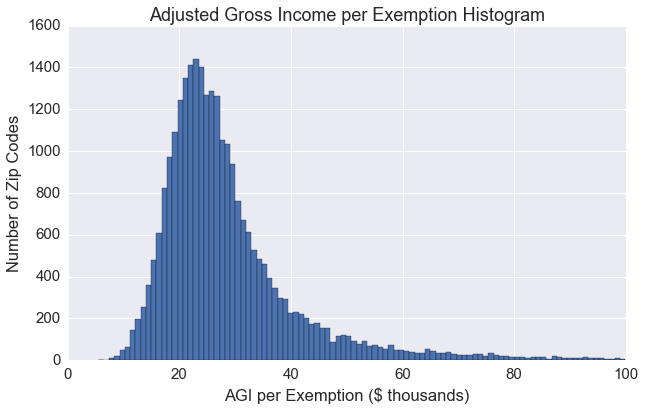

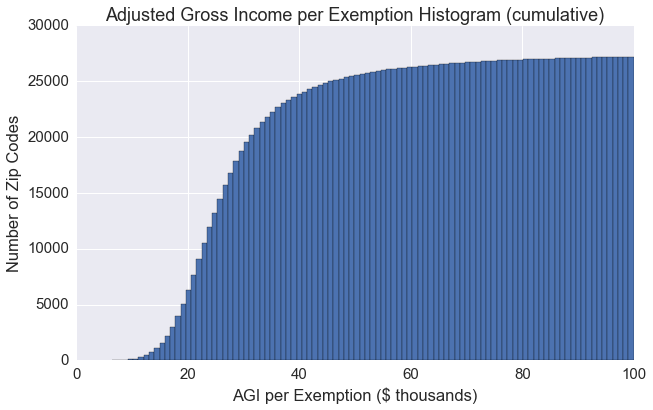

In [370]:
agi_data = map_data.agi_per_exemp
agi_data[agi_data < 100].hist(bins = 100)


plt.title('Adjusted Gross Income per Exemption Histogram')
plt.xlabel('AGI per Exemption ($ thousands)')
plt.ylabel('Number of Zip Codes')
plt.show()

agi_data[agi_data < 100].hist(bins = 100, cumulative = True)
plt.title('Adjusted Gross Income per Exemption Histogram (cumulative)')
plt.xlabel('AGI per Exemption ($ thousands)')
plt.ylabel('Number of Zip Codes')
plt.show()

## Geographical Map of Income

* Using the Basemap package and zip code shapefiles taken from the US Census website, we can map out the income levels by zip code.

* The first map shows all of the zip codes in the dataset.

* Not all of the map is populated (the white spots are missing). Those regions have very few people.

In [365]:
def draw_map(min_quant, max_quant, cbar = False):

    agi_data = map_data.agi_per_exemp
    agi_min = agi_data.quantile(min_quant)
    agi_max = agi_data.quantile(max_quant)
    agi_norm = agi_max - agi_min

    if cbar == False:
        agi_data = agi_data[(agi_data < agi_max) & (agi_data > agi_min)]


    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap = plt.cm.Reds


    my_map = Basemap(projection='lcc', lat_0=57, lon_0=-95, resolution = 'l',\
        llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,lat_1=33,lat_2=45)
 
    my_map.drawcoastlines()
    my_map.drawcountries()
    #my_map.fillcontinents(color='coral')
    my_map.drawmapboundary()
    #my_map.drawmeridians(np.arange(0, 360, 30))
    #my_map.drawparallels(np.arange(-90, 90, 30))

    for record, shape in zip(records,shapes):
        zipcode = int(record[0])
        try:
            agi = agi_data.loc[zipcode]
            if cbar:
                fc = cmap((agi-agi_min)/agi_norm)
            else:
                fc = 'red'
        except KeyError:
            fc = 'none'
        lons,lats = zip(*shape.points)
        x, y = my_map( lons, lats )
        xy = zip(x,y)
        poly = Polygon( xy, facecolor=fc, edgecolor = fc, alpha=1 )
        plt.gca().add_patch(poly)  
        
    if cbar:
        plt.title('Zip Codes Shaded by AGI per Exemption')
    else:
        plt.title('Zip Codes Having AGI per Exemption Between \$ {0:.0f}k and \$ {1:.0f}k'.format(agi_min, agi_max))

    if cbar:
        cax = plt.gcf().add_axes([0.95, 0.2, 0.02, 0.6])
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional',ticks=[0, 0.5, 1])
        cb.set_label('AGI per Exemption')
        cb.ax.set_yticklabels(['<${:.0f}k'.format(agi_min),\
                               '${:.0f}k'.format((agi_min+agi_max)/2),'>${:.0f}k'.format(agi_max)])
    
    
    plt.show()

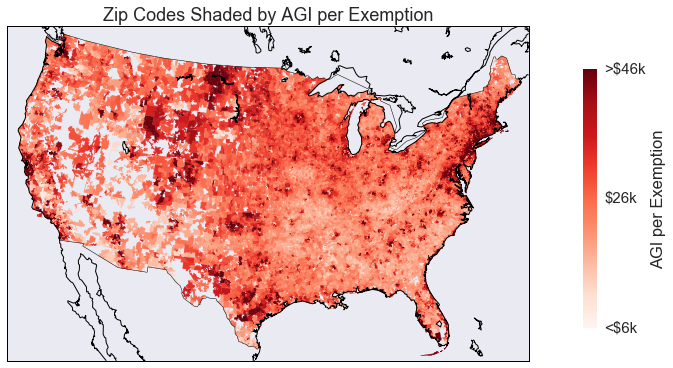

In [372]:
draw_map(0,.9, True)

* The following series of maps shades the areas where the people belonging to different quantiles of personal income live.

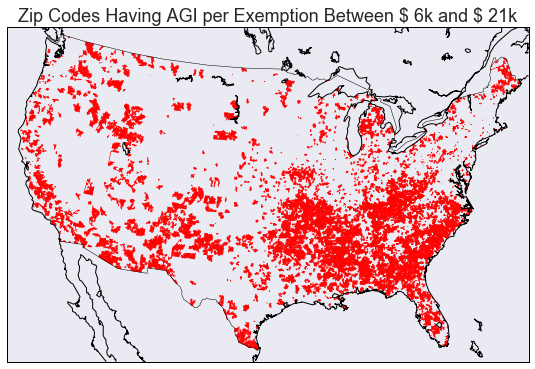

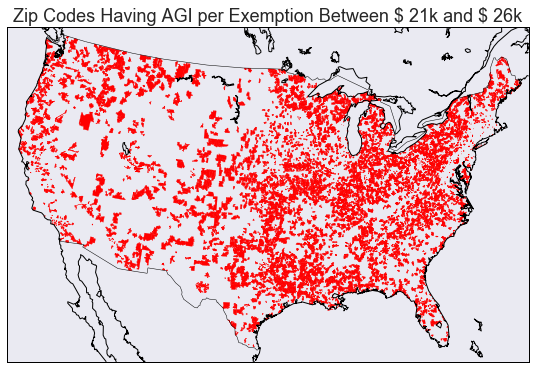

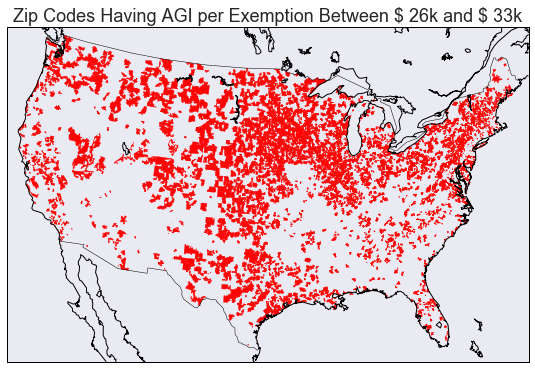

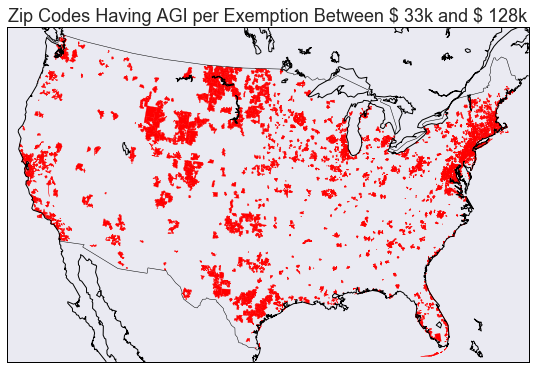

In [376]:
draw_map(0,.25, False)
draw_map(.25,.5, False)
draw_map(.5,.75, False)
draw_map(.75,.99, False)

* The next map represents the top 1% of zip codes (which is not the same as the top 1% of people).

* New York City, San Francisco, and Los Angeles are expected.

* The richest counties in America also include McMullen County, Texas and Teton County, Wyoming. Both of these are clearly visible on the map.

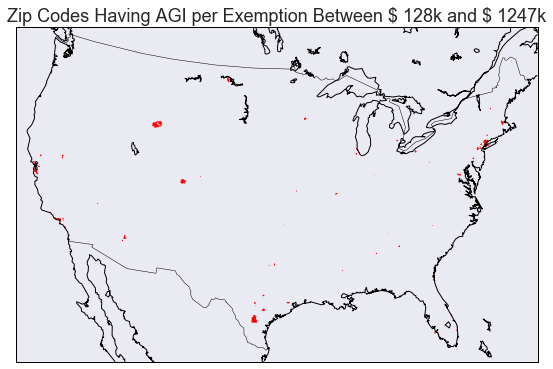

In [375]:
draw_map(.99,1, False)

## Predict Income Using Other Categories

* The tax return contains a lot of other information besides income: business partnerships, foreign taxes paid, etc. 

* Which of these features can be used as predictors of income?

* We can directly answer this question using machine learning to construct a model of income based on these features. 

* Features have to be carefully chosen and normalized.
    * Don't want to accidentally include features that directly give the amount of income.
    * Certain features have to be dropped completely, and others are normalized by dividing by total AGI (for dollar amounts) or total number of returns (for counts).
    
* XGBoost is used to construct the actual model.
    * Feature importance is determined by how often the model makes use of the feature.

In [377]:
year = '14'
number_features = ['mars1', 'MARS2', 'MARS4', 'PREP', 'NUMDEP', 'SCHF', 'num_exemp']
amount_features = []
for col in data[year].columns:
    try:
        int(col[1:])
        if col[0] == 'A':
            amount_features.append(col)
        elif col[0]== 'N':
            number_features.append(col)
    except ValueError:
        pass

In [432]:
model_df = data[year].groupby('zipcode').sum()
model_df.agi_per_exemp = model_df.agi/model_df.num_exemp
model_df.agi_per_return = model_df.agi/model_df.num_returns
for col in number_features:
    model_df[col] = model_df[col]/model_df.num_returns
for col in amount_features:
    model_df[col] = model_df[col]/model_df.agi
model_df = model_df[model_df.num_returns>100][number_features+amount_features+['agi_per_exemp', 'agi_per_return']]

In [439]:
X = model_df.dropna().copy()
#X['Child Tax Credits Amount'] =  X['A11070']+X['A07220']
#X['Child Tax Credits Number'] =  X['N11070']+X['N07220']
X = X.drop(['agi_per_exemp','agi_per_return', 'A05800', 'A04800', 'N04800', 'N05800', 'A06500', 'N06500',\
            'A10300', 'N10300', 'A11902', 'N11902', 'A10600', 'N10600', 'A59660', 'N59660', 'A59720', 'N59720',\
                  'N11070', 'A11070', 'A07220', 'N07220', 'A02650', 'N02650', 'A00101'],axis=1)
Y = model_df.dropna().agi_per_exemp
features = X.columns

labels = {'N00200': '% w/ Wages','A00200': 'Wages/AGI','N85300':'% w/ Investments', 'MARS2' : '% Joint', \
          'A07100': 'Total Credits/AGI' , 'A04470':'Itemized Deductions/AGI', 'num_exemp':'Exemptions per Return',\
         'mars1': '% Single','A85300' : 'Investment Income/AGI', 'A02500':'SS Benefits/AGI', 'N26270':'% w/ S-corp',\
         'agi_per_exemp':'AGI/Exemption', 'NUMDEP':'Dependents/Return'}
X.rename(columns = labels, inplace = True)


X_train, X_cv, Y_train, Y_cv = sklearn.model_selection.train_test_split(X,Y,test_size=0.2)

dtrain = xgb.DMatrix(X_train,label = Y_train)
dcv = xgb.DMatrix(X_cv,label = Y_cv)

#eta = learning rate
#lambda = L2 regulator
params = {'objective':'reg:linear','eta':.2,'max_depth':5, 'lambda':3}
watchlist = [(dtrain, 'train'), (dcv, 'cv')]
num_round = 200

bst = xgb.train(params, dtrain, num_round, watchlist, verbose_eval=50)

[0]	train-rmse:33.5774	cv-rmse:30.7329
[50]	train-rmse:2.49949	cv-rmse:4.86903
[100]	train-rmse:1.71582	cv-rmse:4.58868
[150]	train-rmse:1.33852	cv-rmse:4.48349
[199]	train-rmse:1.1379	cv-rmse:4.43897


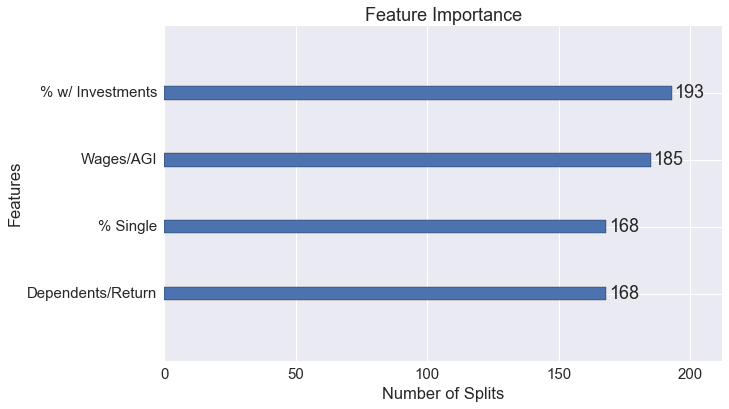

In [450]:
xgb.plot_importance(bst, max_num_features = 4, xlabel = 'Number of Splits', title = 'Feature Importance')
plt.show()

The most important features are
1. the fraction of returns with investement income
2. the fraction of AGI coming from wages
3. the fraction of single returns (as opposed to joint or head-of-household)
4. the number of dependents per return

To look at these features in greater depth, we analyze their correlations with each other and with AGI per Exemption. That is done in the following plots:

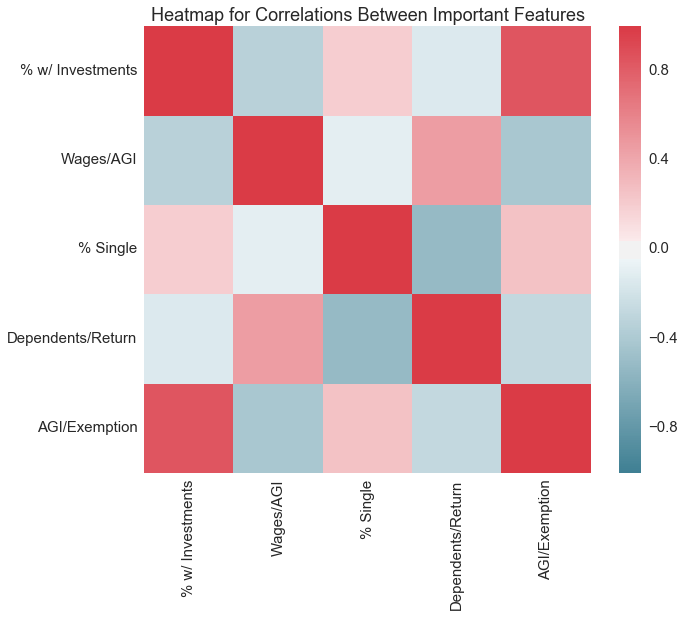

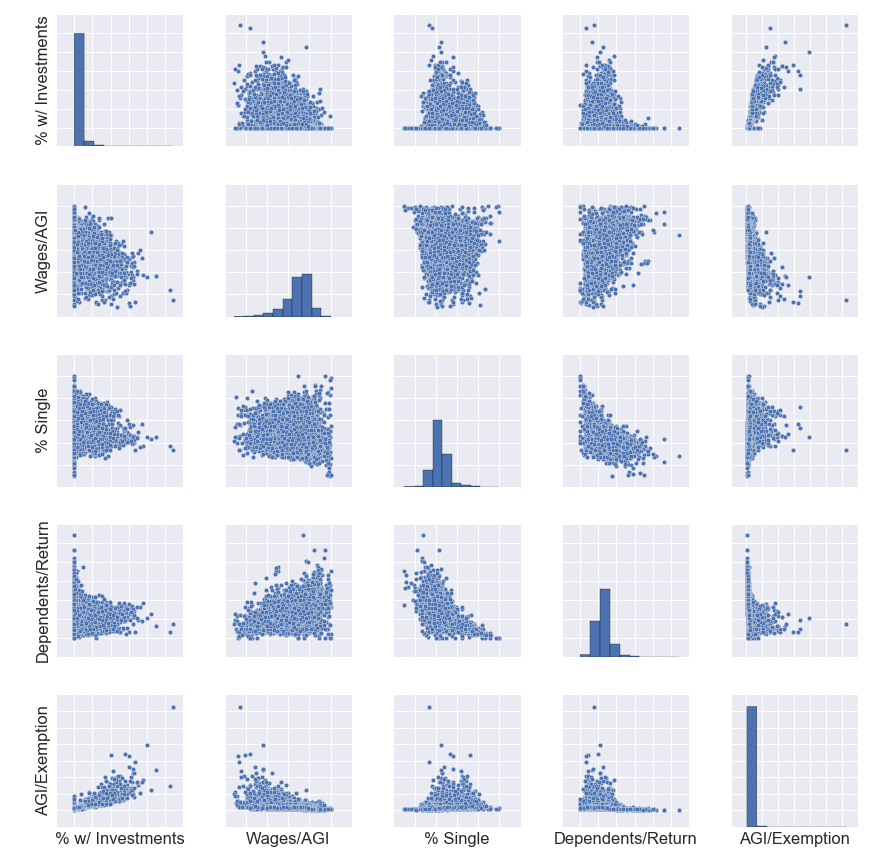

In [448]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model_df.rename(columns = labels, inplace = True)
imp_features = ['% w/ Investments', 'Wages/AGI', '% Single', 'Dependents/Return', 'Total Credits/AGI']
f, ax = plt.subplots(figsize=(10, 8))
corr = model_df[imp_features[:4] + ['AGI/Exemption']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Heatmap for Correlations Between Important Features')
plt.show()
pp = sns.pairplot( model_df[imp_features[:4] + ['AGI/Exemption']])
for i in range(5):
    plt.setp(pp.axes[i,0].get_yticklabels(), visible=False)
    plt.setp(pp.axes[4,i].get_xticklabels(), visible=False)
plt.show()

* % w/Investements has the highest correlation coefficient with AGI/Exemption out of all features at 0.85.
* Wages/AGI has the largest-in-magnitude negative correlation at -0.41
* % Single and Dependents/Return are well-correlated with each other and have moderate correlations with AGI/Exemption.
    * Perhaps their combined effect is useful for the model?

In [449]:
model_df['% Single'].corr(model_df['Dependents/Return'])

-0.51958970506934188

In [425]:
model_df.drop(['A05800', 'A04800', 'N04800', 'N05800', 'A06500', 'N06500',\
            'A10300', 'N10300', 'A11902', 'N11902', 'A10600', 'N10600', 'A59660', 'N59660', 'A59720', 'N59720',\
                  'N11070', 'A11070', 'A07220', 'N07220', 'A02650', 'N02650', 'A00101']\
              ,axis=1).corr()['AGI/Exemption'].sort_values()

Wages/AGI               -0.417463
A07240                  -0.347077
MARS4                   -0.284305
N07240                  -0.284098
Dependents/Return       -0.275193
A09750                  -0.273591
Total Credits/AGI       -0.255051
Exemptions per Return   -0.253412
A01700                  -0.247826
A02300                  -0.213330
N09750                  -0.208677
A10960                  -0.206399
% w/ Wages              -0.201249
A07230                  -0.189273
SS Benefits/AGI         -0.175415
A85775                  -0.132039
A85770                  -0.131399
N02300                  -0.131045
SCHF                    -0.124864
A03210                  -0.122230
A07180                  -0.109196
A03220                  -0.079168
A05780                  -0.051240
N10960                  -0.041112
A11560                  -0.036917
A09400                  -0.011743
N85770                   0.003635
A07260                   0.010560
A03230                   0.015165
N85775        

In [401]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)